In [1]:
import h5py    
import numpy as np    

with h5py.File('./datas/milano.h5', 'r') as hdf:
    ls = list(hdf.keys())
    print("list of the dataset", ls)
    idx = hdf.get('idx')
    idx_arr = np.array(idx)
    print("shape of the idx data", idx_arr.shape)
    cell = hdf.get('cell')
    cell_arr = np.array(cell)
    print("shape of the cell data", cell_arr.shape)
    lat = hdf.get('lat')
    lat_arr = np.array(lat)
    print("shape of the lat data", lat_arr.shape)
    lng = hdf.get('lng')
    lng_arr = np.array(lng)
    print("shape of the lng data", lng_arr.shape)
    net = hdf.get('net')
    net_arr = np.array(net)
    print("shape of the net data", net_arr.shape)
    call = hdf.get('call')
    call_arr = np.array(call)
    print("shape of the call data", call_arr.shape)
    sms = hdf.get('sms')
    sms_arr = np.array(sms)
    print("shape of the sms data", sms_arr.shape)
    k_net_att = list(lng.attrs.keys())
    v_net_att = list(lng.attrs.values())

list of the dataset ['call', 'cell', 'idx', 'lat', 'lng', 'net', 'sms']
shape of the idx data (1344, 1)
shape of the cell data (9953,)
shape of the lat data (9953,)
shape of the lng data (9953,)
shape of the net data (1344, 10000)
shape of the call data (1344, 10000)
shape of the sms data (1344, 10000)


# Premiere approche
Une première approche sera d'observer l'evolution du trafic en considerant la zone dans sa globalité, en faisant la moyenne des valeurs de toutes les zones pour chaque instant.


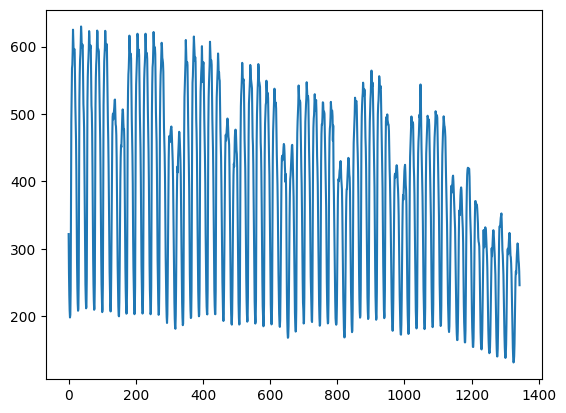

In [2]:
from matplotlib import pyplot as plt 

net_mean = [np.mean(data) for data in net_arr]
plt.plot(net_mean)

plt.show()


On peut aussi faire correspondre les valeurs jour par jour.

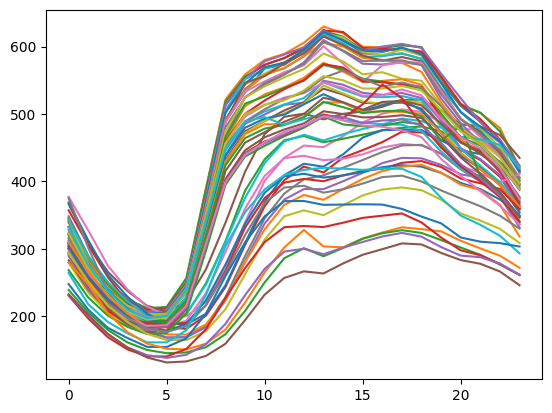

In [3]:
net_mean_days = np.array_split(net_mean, len(net_mean)/24)

for day in net_mean_days:
    plt.plot(day)

On observe un pattern dans l'évolution du trafic au court de la journée.
Il y a aussi des variations dans l'intensité de ce pattern.
Il serait intéressant de voir ce qui peut influencer l'intensité de ces variations.